# SuperCon v2 Dataset Exploration
---

This is a notebook contining some of my initial explorations of the SuperCon2 dataset.

### Dependencies:

To run this notebook you will need to run `pip3 install <dependency>` for all of the packages listed below. These dependencies are preinstalled in this project's associated Docker container:

In [5]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import tqdm
import os

In [6]:
CLEANED_SUPERCON_V2_CSV = './data/Supercon-master/supercon2_cleaned.csv'
CLEANED_SUPERCON_V1_CSV = './data/Supercon-master/supercon1_cleaned.csv'

### Configure Matplotlib

In [7]:
# This sets the pdf rendering to be pdflatex-compatible:
plt.rcParams.update({
    'pgf.texsystem' : 'pdflatex'
})

# use seaborn plot style:
plt.style.use('seaborn')

FIGURES_DIR = './figures2'

### Load & Preprocess Data:

In [8]:
supercon1_df = pd.read_csv(CLEANED_SUPERCON_V1_CSV)
supercon2_df = pd.read_csv(CLEANED_SUPERCON_V2_CSV)

supercon_all_df = pd.concat([supercon1_df, supercon2_df])

In [9]:
supercon_all_df # render in notebook

,Material,Substitutions,Tc (K),Pressure (GPa),Classes,Shape,Substrate,DOI
0,Ba 0.4 K 0.6 Fe 2 As 2,{},31.20,0.0,"['Oxides', 'Cuprates']",NaN,NaN,10.1038/s41524-018-0085-8
1,Ca 0.4 Ba 1.25 La 1.25 Cu 3 O 6.98,{},40.10,0.0,"['Oxides', 'Cuprates']",NaN,NaN,10.1038/s41524-018-0085-8
2,Mo 0.39 Ru 0.61,{},6.90,0.0,"['Oxides', 'Cuprates']",NaN,NaN,10.1038/s41524-018-0085-8
3,Tm 4 Os 6 Sn 19,{},1.10,0.0,"['Oxides', 'Cuprates']",NaN,NaN,10.1038/s41524-018-0085-8
4,Nd Bi 0.99 Pb 0.01 S 2 F 0.3 O 0.7,{},4.85,0.0,"['Oxides', 'Cuprates']",NaN,NaN,10.1038/s41524-018-0085-8
...,...,...,...,...,...,...,...,...
23876,Nb Se 2,{},7.00,0.0,['Chalcogenides'],nanobelts,NaN,10.1103/physrevb.75.020501
23877,Mg B 2,{},40.00,0.0,"['Alloys', 'Borides']",NaN,NaN,10.1103/physrevb.66.012511
23878,Ca Bi 2,{},2.00,0.0,['Alloys'],NaN,NaN,NaN
23879,Ca Bi 2,{},2.00,0.0,['Alloys'],single-crystalline,NaN,NaN


## Visualize Distribution of Data:

In [10]:
from pymatgen.util.plotting import periodic_table_heatmap
from sctk.materials import PeriodicTable, Material

composition_freq = { str(e) : 0 for e in PeriodicTable.keys() }

for i, row in supercon_all_df.iterrows():
    m = Material(row['Material'])
    if m:
        for elem in m.get_composition().keys():
            composition_freq[str(elem)] += 1
            

<Figure size 600x260 with 0 Axes>

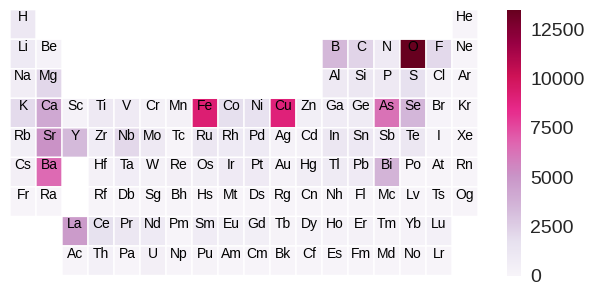

In [84]:
from matplotlib import cm

plt.figure(figsize=(6,2.6))
periodic_table_heatmap(composition_freq, 
                       cmap='PuRd', 
                       symbol_fontsize=10,
                       cmap_range=(0,max(composition_freq.values())),
                       blank_color=cm.get_cmap('PuRd')(0.0))
plt.gcf().set_size_inches(6,2.8)
#plt.annotate('Supercon v1 + v2 Dataset Distribution', (2.0,0.6), 
#             fontweight='bold', fontsize=14)
# save figure:
if FIGURES_DIR is not None:
    figpath = os.path.join(FIGURES_DIR,'supercon2_ptable.pdf')
    plt.savefig(figpath, backend='pgf')
plt.show()

In [12]:
classes = set()
for _, row in supercon_all_df.iterrows():
    classes |= set(eval(row['Classes']))

print('Classes\n------------------------')
for i, c in enumerate(classes):
    print(i+1,':',c)

Classes
------------------------
1 : Iron-chalcogenides
2 : Hydrides
3 : Pnictides
4 : Oxides
5 : Iron-pnictides
6 : Nitrides
7 : Carbides
8 : Chalcogenides
9 : Borides
10 : Alloys
11 : Fluorides
12 : Cuprates


In [13]:
def parse_tags(row):
    # read structure info:
    structure = str(row['Shape'])
    tags = {
        'applied_pressure' : (row['Pressure (GPa)'] > 0),
        'polycrystaline': False,
        'thin_film': False,
    }
    
    if 'flake' in structure or \
       'film' in structure or \
       'layer' in structure:
        tags['thinfilm'] = True
    if 'poly' in structure or 'polly' in structure:
        tags['polycrystaline'] = True
        
    return tags

def parse_metadata(row):
    NaN = float('NaN')
    metadata = {}
    
    # parse row entries:
    metadata['Material'] = row['Material']
    metadata['Substitutions'] = eval(row['Substitutions'])
    metadata['Tc (K)'] = row['Tc (K)']
    metadata['Pressure (GPa)'] = row['Pressure (GPa)']
    metadata['Classes'] = eval(row['Classes'])
    metadata['Shape'] = row['Shape'] if row['Shape'] != NaN else None
    metadata['Substrate'] = row['Substrate'] if row['Substrate'] != NaN else None
    metadata['DOI'] = row['DOI'] if row['DOI'] != NaN else None
    
    # parse classifier tags:
    metadata['Tags'] = parse_tags(row)
    
    return metadata

class_dict = { c : [] for c in classes }

exclusive_classes_ordered = [
    'Cuprates',
    'Iron-Based',
    'Alloys',
    'Non-Cu Oxides',
    'Hydrides',
    'Other',
]
exclusive_classes = { 
    k : [] for k in exclusive_classes_ordered
}

for _, row in supercon_all_df.iterrows():
    
    row_classes = eval(row['Classes'])
    row_mat = Material(row['Material'])
    row_metadata = parse_metadata(row)
    row_data = (row_mat, row_metadata)
    
    for c in row_classes:
        class_dict[c].append(row_data)
        
    if 'Cuprates' in row_classes:
        exclusive_classes['Cuprates'].append(row_data)
    elif 'Iron-chalcogenides' in row_classes or \
         'Iron-pnictides' in row_classes:
        exclusive_classes['Iron-Based'].append(row_data)
    elif 'Hydrides' in row_classes:
        exclusive_classes['Hydrides'].append(row_data)
    elif 'Alloys' in row_classes:
        exclusive_classes['Alloys'].append(row_data)
    elif 'Oxides' in row_classes:
        exclusive_classes['Non-Cu Oxides'].append(row_data)
    else:
        exclusive_classes['Other'].append(row_data)
        

In [14]:
from pprint import pprint

exclusive_classes_increasing = sorted(
    exclusive_classes.keys(), key=lambda k : len(exclusive_classes[k]))

pprint({ k : len(v) for k,v in class_dict.items()})
pprint({ k : len(v) for k,v in exclusive_classes.items()})


{'Alloys': 8207,
 'Borides': 2534,
 'Carbides': 1156,
 'Chalcogenides': 3858,
 'Cuprates': 14327,
 'Fluorides': 1342,
 'Hydrides': 654,
 'Iron-chalcogenides': 2026,
 'Iron-pnictides': 4569,
 'Nitrides': 456,
 'Oxides': 17984,
 'Pnictides': 5361}
{'Alloys': 7988,
 'Cuprates': 14327,
 'Hydrides': 534,
 'Iron-Based': 6586,
 'Non-Cu Oxides': 1742,
 'Other': 5122}


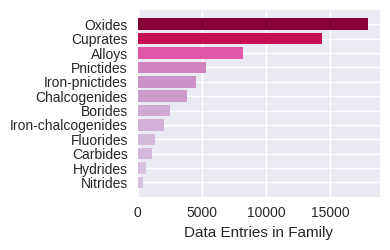

In [15]:
# plot counts for each family:
plt.figure(figsize=(4,2.6))
family_counts = [ (k,len(v)) for k,v in class_dict.items() ]
family_counts.sort(key=lambda x : x[1])

barticks = []
plt.grid(zorder=-1)
for x, (k, n) in enumerate(family_counts):
    plt.barh(x, n, label=k, zorder=3, color=cm.get_cmap('PuRd')((n + 5000)/25000))
    barticks.append(k)

#plt.legend()
plt.yticks(list(range(len(family_counts))))
plt.gca().set_yticklabels(barticks)
plt.xlabel('Data Entries in Family')
plt.tight_layout()

# save figure:
if FIGURES_DIR is not None:
    figpath = os.path.join(FIGURES_DIR,'supercon2_families.pdf')
    plt.savefig(figpath, backend='pgf')
plt.show()

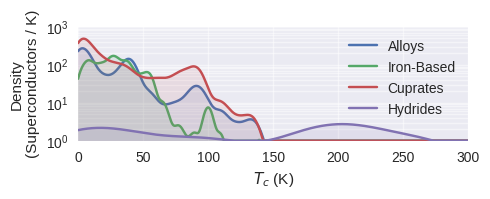

In [82]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

plot_groups = ['Alloys', 'Iron-Based', 'Cuprates', 'Hydrides']

family_Tcs = {
    k : np.array([ d[1]['Tc (K)'] for d in exclusive_classes[k] ])
    for k in plot_groups
}

family_Tc_kdes = {
    k : (len(tcs),gaussian_kde(tcs))
    for k, tcs in family_Tcs.items()
}

tc_x = np.linspace(0,300,1000)
tc_max=300

plt.figure(figsize=(5,2))
for k in plot_groups:
    (N,kde) = family_Tc_kdes[k]
    plt.plot(tc_x, np.maximum(1, N*kde(tc_x)), zorder=3, label=k)
    plt.fill_between(tc_x, np.maximum(1, N*kde(tc_x)), alpha=0.1, zorder=3)
plt.grid(zorder=-1, which='both', alpha=0.5)
plt.yscale('log')
plt.ylim(1.0, 10**3)
plt.xlim(0,tc_max)
plt.ylabel('Density\n(Superconductors / K)')
plt.xlabel(r'$T_c$ (K)')
plt.legend()
plt.tight_layout()

# save figure:
if FIGURES_DIR is not None:
    figpath = os.path.join(FIGURES_DIR,'supercon2_Tcs.pdf')
    plt.savefig(figpath, backend='pgf')
plt.show()

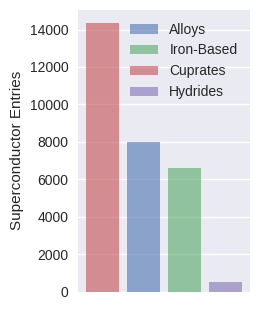

In [64]:
plt.figure(figsize=(2.7,3.2))

class_counts = {
    k : len(exclusive_classes[k])
    for k in plot_groups
}

positions = list(range(len(plot_groups)))
positions.sort(key=lambda i : -class_counts[plot_groups[i]])

for i, k in enumerate(plot_groups):
    n = class_counts[k]
    plt.bar(positions.index(i), n, log=False, label=k, alpha=0.6)
    
plt.legend()
plt.gca().set_xticks([])
plt.ylabel('Superconductor Entries')
plt.tight_layout()

# save figure:
if FIGURES_DIR is not None:
    figpath = os.path.join(FIGURES_DIR,'supercon2_bars.pdf')
    plt.savefig(figpath, backend='pgf')
plt.show()

In [65]:
from sctk.structure import composition_distance

# Example Materials:
example_materials = {
    'Alloys' : Material('NbTi'),
    'Iron-Based' : Material('LaOFeAs'),
    'Cuprates' : Material('YBa2Cu3O7'),
    'Hydrides' : Material('H3S'),
}

example_material_matches = {
    k : [] for k in example_materials
}

for _, row in supercon_all_df.iterrows():
    m = Material(row['Material'])
    tc = row['Tc (K)']
    for k, kmat in example_materials.items():
        if None not in m.get_composition().values() \
          and composition_distance(m, kmat) < 0.001:
            example_material_matches[k].append(tc)

NbTi 13.4 7.797506724018333
LaOFeAs 27.366305418719215 14.17665188836427
YBa₂Cu₃O₇ 81.48561904761904 21.05863516690886
H₃S 184.18333333333334 50.01682772383266


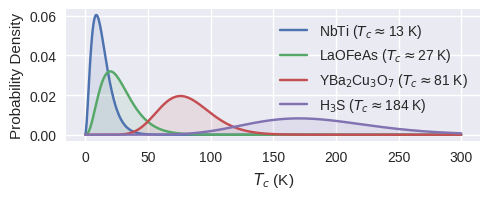

In [79]:
from scipy.stats import gamma

plt.figure(figsize=(5,2.1))
for k, tcs in example_material_matches.items():
    mat = example_materials[k]
    mean = np.mean(tcs)
    std = np.std(tcs)
    kappa = mean**2/std**2
    theta = std**2/mean
    
    t = np.linspace(0,300, 1000)
    prob = gamma.pdf(t,a=kappa, scale=theta)
    
    print(mat.str(), mean, std)
    plt.plot(t,prob, label=mat.str(fmt='latex') + r' ($T_c \approx$' + f'{mean:.0f} K)')
    plt.fill_between(t,prob, alpha=0.1)
plt.ylabel('Probability Density')
plt.xlabel(r'$T_c$ (K)')
plt.legend()
plt.tight_layout()
    
# save figure:
if FIGURES_DIR is not None:
    figpath = os.path.join(FIGURES_DIR,'supercon2_Tc_gammas.pdf')
    plt.savefig(figpath, backend='pgf')
plt.show()